pillcam dataset split into neg/pos and trained using resnet.py witouth augmentation or ds normalization.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import time
start_time = time.time()

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MODEL = 'resnet50'
DS_INFO = 'binary'
NUM_EPOCHS = 2
BATCH_SIZE = 64
IMG_HEIGHT = 64  #224
IMG_WIDTH = 64

NUM_CHANNELS = 3
NUM_CLASSES = 2
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [4]:
def print_class_info(names, pos, neg):
    # Extract and print info about the class split 
    
    list_class = [pos, neg]
    idx = 0
    for class_ in list_class:
        print ("{} class names:".format(names[idx]))
        for cl in class_:
            print ("{}- {}".format(" "*8, cl))
        idx += 1
    
    neg_count = 0
    pos_count = 0
    for class_name in original_class_names:
        # Number of samples in 'class_name' folder
        class_samples = len(list(data_dir.glob(class_name+'/*.jpg')))

        if (class_name == neg_class_name[0]):
            neg_count += class_samples
        else:
            pos_count += class_samples

    print ('\nNegative samples: {0:5} | {1:5.2f}%'.format(neg_count, neg_count/DATASET_SIZE*100))
    print ('Positive samples: {0:5} | {1:5.2f}%'.format(pos_count, pos_count/DATASET_SIZE*100))
    # Print number of images in dataset (excluded samples in outcast)
    print ('\nTotal number of images:', DATASET_SIZE)

In [6]:
# data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')
outcast = 'polyps'

DATASET_SIZE = len(list(data_dir.glob('[!'+str(outcast)+']*/*.jpg')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Classes in data_dir: ", class_names)

# Remove outcasts
original_class_names = np.delete(class_names, np.where(outcast == class_names))
print ("\nRemoved outcast: ", outcast, "\n")

class_names = np.array(['Negative', 'Positive'])
neg_class_name = ['normal-pylorus']
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

print_class_info(class_names, pos_class_names, neg_class_name)

Classes in data_dir:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

Removed outcast:  polyps 

Negative class names:
        - esophagitis
        - ulcerative-colitis
        - normal-cecum
        - normal-z-line
        - dyed-resection-margins
        - dyed-lifted-polyps
Positive class names:
        - normal-pylorus

Negative samples:  1000 | 14.29%
Positive samples:  6000 | 85.71%

Total number of images: 7000


In [7]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(outcast+']*/*'))

Set up pipeline for loading images from given list of paths

In [8]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.uint8),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.uint8),[-1])

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

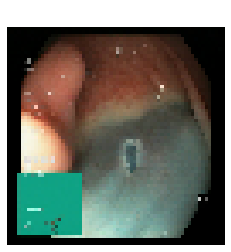

In [9]:
def show_image(img):
    for image, label in img:
        plt.figure();
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

In [10]:
end_time = time.time()
print ("Run time: ", end_time-start_time)

Run time:  34.454763650894165


### Splitting into training, test and validation data

In [11]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [12]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:         7000
Train dataset sample size:        4900
Test dataset sample size:         1050
Validation dataset sample size:   1050


In [13]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/train_{}.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/test_{}.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/val_{}.tfcache".format(IMG_WIDTH))

## Training
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [14]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers

In [15]:
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

In [16]:
res_net.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')

tl_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [17]:
tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
tl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/transfer_learning_model', update_freq='batch')]

In [19]:
history = tl_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 76 steps, validate for 16 steps
Epoch 1/2
76/76 [==============================] - 47s 620ms/step - loss: 0.2158 - accuracy: 0.9180 - val_loss: 0.6347 - val_accuracy: 0.8516
Epoch 2/2
76/76 [==============================] - 2s 27ms/step - loss: 0.0986 - accuracy: 0.9644 - val_loss: 0.6291 - val_accuracy: 0.8486


`Keras`
Save/load the model

In [ ]:
# tl_model.save('models/{}.h5'.format(model_name))
# tl_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

`Tensorboard`

In [ ]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [ ]:
# Start tensorboard
%tensorboard --logdir logs

In [ ]:
# !kill 20058

In [ ]:
result = tl_model.evaluate(
            val_ds,
            steps = val_size//BATCH_SIZE)

## Predict new samples

In [20]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

True label: Positive
Probabibity of Positive: 56.73239%


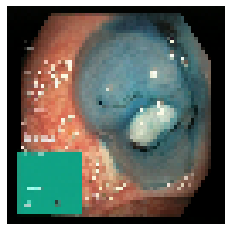

In [21]:
# Get a random image and label
idx = np.random.randint(0, BATCH_SIZE)
idx = 4
image = images[idx]
label = labels[idx]

# Predict one image
result = tl_model.predict(np.expand_dims(image, axis=0))[0][0]

print ("True label:", class_names[label[0]])
print ('Probabibity of Positive: {:.5f}%'.format((result)*100))

plt.figure()
plt.imshow(image)
plt.axis('off');

In [22]:
# Predict one batch
results = tl_model.predict(images)

print ('{:3}  {:7}  {:3}%'.format('idx', 'true_label', 'pred_prob'))
print ('---  ---------   ----------')
idx = 0
for result in results:
    true_label = class_names[labels[idx]][0]
    pred_prob = result[0]
    print ('{:3}  {:10}  {:05f}%'.format(idx, true_label, pred_prob))
    idx += 1

idx  true_label  pred_prob%
---  ---------   ----------
  0  Positive    0.514032%
  1  Positive    0.537211%
  2  Positive    0.564567%
  3  Positive    0.567657%
  4  Positive    0.567324%
  5  Positive    0.549798%
  6  Positive    0.542472%
  7  Positive    0.538508%
  8  Positive    0.552294%
  9  Positive    0.581509%
 10  Negative    0.553104%
 11  Positive    0.547706%
 12  Positive    0.557886%
 13  Positive    0.531774%
 14  Positive    0.556407%
 15  Positive    0.557691%
 16  Negative    0.545023%
 17  Positive    0.567231%
 18  Negative    0.565621%
 19  Positive    0.582416%
 20  Positive    0.565889%
 21  Positive    0.542971%
 22  Positive    0.511304%
 23  Positive    0.538523%
 24  Positive    0.559552%
 25  Positive    0.514832%
 26  Negative    0.569405%
 27  Positive    0.550963%
 28  Positive    0.568991%
 29  Positive    0.538740%
 30  Positive    0.523689%
 31  Positive    0.543027%
 32  Positive    0.513834%
 33  Negative    0.557575%
 34  Positive    0.527534%